In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm

In [2]:
# Get raw data
google_data = pd.read_excel("Lecture1_data.xlsx", sheet_name="goog_mret")
ff_factors = pd.read_excel("Lecture1_data.xlsx", sheet_name="ff_factors")

# Rename ff_factors columns, subset to relavent years

ff_factors.columns = ["Date", "XRM", "SMB", "HML", "rf_ret", "MOM"]
ff_factors["Date"] = pd.to_datetime(ff_factors["Date"])
ff_factors["yyyymm"] = ff_factors.Date.dt.year*100 + ff_factors.Date.dt.month
subset_ff_factors = ff_factors.loc[ff_factors.Date.dt.year >= 2005]
ff_factors = subset_ff_factors.reset_index()

google_data["Date"] = pd.to_datetime(google_data["Date"])
google_data["yyyymm"] = google_data.Date.dt.year*100 + google_data.Date.dt.month

# print(ff_factors)
# print(google_data)

In [3]:
# merge the data set to ensure timing is right

ret_matrix = pd.merge(google_data, ff_factors, on="yyyymm") # Figure out how this method works

print(ret_matrix)

     PERMNO     Date_x Ticker Symbol   Returns  Shares Outstanding  yyyymm  \
0     90319 2005-01-31          GOOG  0.014679               95542  200501   
1     90319 2005-02-28          GOOG -0.039004               95542  200502   
2     90319 2005-03-31          GOOG -0.039789              114754  200503   
3     90319 2005-04-29          GOOG  0.218769              171218  200504   
4     90319 2005-05-31          GOOG  0.260318              171218  200505   
..      ...        ...           ...       ...                 ...     ...   
187   90319 2020-08-31         GOOGL  0.095151              300471  202008   
188   90319 2020-09-30         GOOGL -0.100600              300641  202009   
189   90319 2020-10-30         GOOGL  0.102695              300644  202010   
190   90319 2020-11-30         GOOGL  0.085570              300644  202011   
191   90319 2020-12-31         GOOGL -0.001003              300644  202012   

     index     Date_y     XRM     SMB     HML  rf_ret     MOM  

In [4]:
# Get the relavent returns
google_ret = ret_matrix["Returns"]
market_ret = ret_matrix["XRM"]
rf_ret = ret_matrix["rf_ret"]

excess_ret = google_ret - rf_ret

In [5]:
# Do a linear regression on excess return vs market return
# get coefficient, intercept and R^2 value; 
(beta, alpha, r2val) = stats.linregress(market_ret, excess_ret)[0:3]

# OLS with 1 variable to get t-statistics

x = sm.add_constant(market_ret)
model = sm.OLS(excess_ret, x).fit()
# predictions = model.predict(x) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     75.79
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           1.51e-15
Time:                        11:01:19   Log-Likelihood:                 239.94
No. Observations:                 192   AIC:                            -475.9
Df Residuals:                     190   BIC:                            -469.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.005      1.867      0.0

### What Prof Huang discuessed in class (Check recording 2 from Linear Asset Pricing Model Lec @ 30 mins)
* Const is the intercept (alpha)
* XRM (excess market return) x variable (beta)


> coef is the estimate for each of the variables

### Now let's look at the t stats from the table above:

> Are the coefficient estimates statistically significantly different than 0? (Significance Level)
* So is the alpha (const) result statistically significant? (Yes at 90% confidence interval only because it has a value greater than 1.66) - so you should reject CAPM model for this stock
* Last two columns gives you the confidence interval (You dont need to know this?)

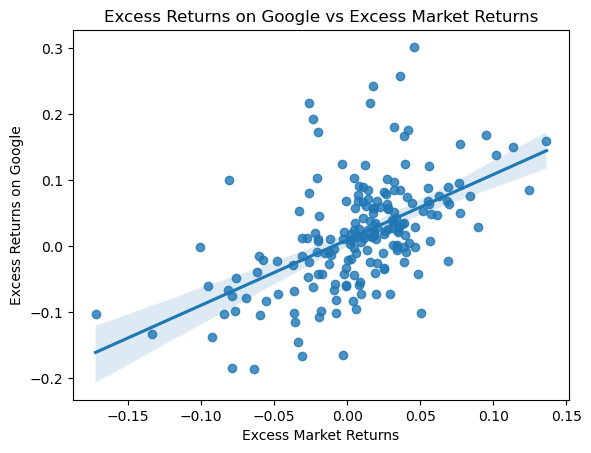

In [6]:
sns.regplot(x = market_ret, y= excess_ret) # TODO prof huang will update this after the lecture since the intercept is wack
plt.xlabel("Excess Market Returns")
plt.ylabel("Excess Returns on Google")
plt.title("Excess Returns on Google vs Excess Market Returns")
plt.show()

In [7]:
print("The stock's beta is", round(beta, 4))
print("The stock's alpha is", round(alpha,5)) # y intercept
print("The R^2 coefficient is", round(r2val,3)) # R^2 is how correlated google is to market return

The stock's beta is 0.9906
The stock's alpha is 0.00955
The R^2 coefficient is 0.534


In [8]:
# multiple-regression here: regression model: excess_ret = function (market_return, SMB, HML). Output intercept, 
# and each of the coefficient estimates, and their associated t-statistics.
# Get coefficients using first method

explanatory_variates = ret_matrix[["XRM", "SMB", "HML"]]
explanatory_variates
model1 = linear_model.LinearRegression().fit(explanatory_variates, excess_ret)
print('Intercept: \n', model1.intercept_)
print('Coefficients: \n', model1.coef_)


Intercept: 
 0.006906452915682003
Coefficients: 
 [ 1.17723538 -0.46744799 -0.51804095]


In [9]:
# Another method, also gives t-statistics

x = sm.add_constant(explanatory_variates)
model2 = sm.OLS(excess_ret, x).fit()
predictions = model2.predict(x) 
 
print_model = model2.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     31.14
Date:                Thu, 18 Jan 2024   Prob (F-statistic):           2.18e-16
Time:                        11:01:19   Log-Likelihood:                 246.44
No. Observations:                 192   AIC:                            -484.9
Df Residuals:                     188   BIC:                            -471.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0069      0.005      1.372      0.1

## Now we have 3 explanitory variables

* We have a bunch of estimates now 

* **What can we say about the results we get (for XRM, SMB, HML????)** 